# TP 3 : classification de documents

(inspiré pour partie d'un TP par Antoine Simoulin)

La **classification de textes** est la tâche qui prend en entrée du texte, et prédit en sortie une ou plusieurs classes pour ce texte, l'important étant que l'ensemble des classes possibles est connu et fixé a priori.

## Exemples de tâches relevant de la "classification de texte"

De nombreuses applications de TAL correspondent à de la classification de textes. Par exemple :
* L'"**analyse de sentiments**" (ou "sentiment analysis"): est un nom pompeux pour la tâche d'identification de  la polarité positive ou négative d'un texte, appliqué par exemple pour déterminer
  * ce client est-il content ou pas?
  * ce spectateur a-t-il aimé ce film ou pas?
  * ...
* La détection de Spam dans les Emails
* Le suivi de tendances sur les réseaux sociaux
* Recherche de réponse dans une FAQ...


## Les données 

On utilise les données de classification de textes pour le français, telles qu'inclusent dans les données FLUE <a href="https://aclanthology.org/2020.lrec-1.302/">(Le et al., 2020)</a>, cf. le repo https://github.com/getalp/Flaubert/tree/master/flue.

Nous utilisons ici un extrait de la partie française d'un corpus d'"analyse de sentiment" multilingue, le corpus CLS <a href="https://aclanthology.org/P10-1114/">(Prettenhofer and Stein, 2010)</a>.

Les textes sont des revues par des utilisateurs, issues du site Amazon pour trois catégories de produits (livres, DVD et musique). Initialement, chaque exemple contenait une revue associée à une note allant de 1 à 5, mais les revues avec une note de 3 ont été écartées, et les notes ont été binarisées: 1/2 devient 0 ("négatif"), et 4/5 devient 1 ("positif"). 

Pour chaque catégorie de produit (livres, dvd, musique), les données cls-fr de FLUE contiennent 2000 revues de test, et 2000 revues d'apprentissage. Pour ce TP, nous avons en outre divisé les 2000 revues d'apprentissage en 1600 pour l'entraînement, et 400 pour la validation.



### Import des librairies

In [1]:
%%capture

# ⚠️ Execute only if running in Colab
if 'google.colab' in str(get_ipython()):
  IN_COLAB = True
else:
  IN_COLAB = False

if IN_COLAB:
  !pip install -q scikit-learn==0.23.2 matplotlib==3.3.2 pandas==1.1.3 nltk==3.5 spacy==2.3.2 
  !python3 -m spacy download fr_core_news_md
  # if running Colab, restart after libraries installation (Redémarrer l'environnement d'exécution)
  # exit()

In [2]:
import os, sys
import numpy as np  # python base math library
import pandas as pd # data structure

from collections import Counter
#from pprint import pprint
#from time import time
import logging
import itertools
import matplotlib.pyplot as plt

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')

# IPython automatically reload all changed code
%load_ext autoreload
%autoreload 2

# Inline Figures with matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
def load_cls_file(file_path):
    reviews, labels = [], []
    with open(file_path,encoding='utf-8') as f:
        line = f.readline()
        while line:
            review, label = line.strip().split('\t')
            reviews.append(review.strip("\""))
            labels.append(int(label))
            line = f.readline()
    return reviews, labels

def load_cls_dataset(file_path, section='books'):
    part2X, part2y = {}, {}
    for part in ['train', 'valid']:  
        part2X[part], part2y[part] = load_cls_file(os.path.join(file_path, section, part+'_0.tsv'))
    return part2X, part2y

## Chargement des données

In [4]:
data_dir = './data_flue_cls_fr/'

In [5]:
X = {} # key1=cat, key2=part, val= list of reviews
y = {} # key1=cat, key2=part, val= list of labels
y_train = [] # les labels "gold" pour la partie train
y_valid = [] # les labels "gold" pour la partie validation
for genre in ['books', 'dvd', 'music']:
    X[genre], y[genre] = load_cls_dataset(data_dir, genre)
    y_train += y[genre]['train']
    y_valid += y[genre]['valid']

In [6]:
df = {} # key=cat, val = data frame
for part in ['train', 'valid']:
    df[part] = pd.DataFrame.from_dict(
    {'review': X['books'][part] + X['dvd'][part] + X['music'][part],
     'label': y['books'][part] + y['dvd'][part] + y['music'][part],
     'genre': ['books' for _ in range(len(X['books'][part]))] \
             + ['dvd' for _ in range(len(X['dvd'][part]))] \
             + ['music' for _ in range(len(X['music'][part]))]})

id2label = ['Négatif', 'Positif']

In [7]:
pd.options.display.max_colwidth = 300
df['train'].head(10)

,review,label,genre
0,"Je voulais mettre 0 étoile mais c'est pas possible... Commençons par le positif (c'est rapide): ça parle de tout : muxle, endurance, souplesse, alimentation, échauffement mais ... mal, désespérement mal. L'auteur prétend avoir fait 15 ans de recherche avant de pondre son opus majus. Ben faudrait...",0,books
1,"Le récit de vie d'une femme américaine, avec ses contradictions, ses rêves de liberté, de justice (dans l'amérique de la guerre du Vietnam). Un récit qui n'est pas prêt de me quitter sur la complexité de la nature humaine dans ce qu'elle a de plus tortueux et de plus insaisissable. Un récit cons...",1,books
2,"Quel chef d'oeuvre que cette 'autobiographie' ! C'est à croire que la vie de Michaël Crichton est aussi palpitante, voire plus par moments, que celle des personnages de ses romans... Que d'aventures, de découvertes, d'expérience ! On comprend mieux, après la lecture de cet ouvrage, d'où lui vien...",1,books
3,"Si vous cherchez un livre simple d'initiation à Scheme pour comprendre et modifier les Script-Fu de Gimp, ne faites pas comme moi, choisissez-en un autre. Si vous voulez étudier ce langage d'un point de vue théorique, sans allumer votre ordinateur, en entrant dans le détail des algorithmes, sans...",1,books
4,Ce livre est très intéressant à lire à plus d'un titre. Certes JF Revel voit juste dans son analyse au sujet de la pensée ambiante vis-à-vis des USA. Cependant il manque totalement de rigueur scientifique (beaucoup d'assertions sans références bibliographiques). Cet ouvrage bien qu'éclairant ne ...,0,books
5,"J'avais déjà été déçue par """"Dossier Benton"""". Mais là, que dire de """"L'Ile des Chiens"""" ??? Quel ennui ! Les personnages sont burlesques, et l'intrigue initéressante ! Je suis pourtant une inconditionnelle de celle que je considérais comme LA reine du thriller. On ne ressuscitera pas Benton, ma...",0,books
6,"Michel Hoàng trace un portrait captivant du plus grand conquérant de l'histoire. Il dépeint les mœurs de ces nomades de la steppe qui engendreront Tèmudjin, le fils de petit chef qui s'élèvera au range de Khan océanique. L'ascension lente et patiente faite à coup d'alliances et « desalliance » d...",1,books
7,"Que lui avons-nous fait? Pourquoi la belle Amélie se croit-elle obligée de nous décevoir chaque année? Si le but est de nous prouver que le génie ne s'utilise pas comme une clé de 12, la démonstration en a été faite depuis longtemps.",0,books
8,"Il y a deux manières d'envisager ce livre. Sur le plan de la méthode, Encel expose le Golan d'un point de vue géopolitique, ce qui peut être pertinent... jusqu'à un certain point. En effet, au-delà de certaines imprécisions, voire confusions dans la réalité historique du Golan, l'auteur en vient...",0,books
9,"On s'attend avec ce livre à découvrir un pays, une époque, et surtout lire un roman d'espionnage, quelque chose de palpitant, qui s'emballe, un livre que l'on ne peut plus quitter quand on l'a ouvert. Malheureusement, le scénario s'essouffle au fil des pages, pour devenir carrément asthmatique à...",0,books


## Exploration des données

Avant de commencer à dérouler un cas d'usage, vous devez toujours **analyser les données**. Vérifiez les valeurs manquantes ou abérrantes, la distribution des variables, l'équilibre des classes, sélectionnez ou écartez les variables en fonction de leur pertinence ou selon des critères éthiques.

### TODO1: Comparer la distribution des labels positifs / négatifs, et des genres (music, dvd, books) entre le corpus train et le corpus de test

######  comparaison des distributions des labels positifs/négatifs entre le corpus train et le corpus de test

In [24]:
train_num_label_positive  = df['train'][df['train']['label'] == 1].shape[0]
train_num_label_negative  = df['train'][df['train']['label'] == 0].shape[0]
train_prop_label_positive = (train_num_label_positive/(train_num_label_positive+ train_num_label_negative))*100
train_prop_label_negative = (train_num_label_negative/(train_num_label_positive+ train_num_label_negative))*100
print("propotion de labels positifs dans le corpus train est :", train_prop_label_positive)
print("propotion de labels négatifs dans le corpus test est :", train_prop_label_negative)

propotion de labels positifs dans le corpus train est : 49.98958116274223
propotion de labels négatifs dans le corpus test est : 50.01041883725777


In [27]:
valid_num_label_positive  = df['valid'][df['valid']['label'] == 1].shape[0]
valid_num_label_negative  = df['valid'][df['valid']['label'] == 0].shape[0]
valid_prop_label_positive = (valid_num_label_positive/(valid_num_label_positive+ valid_num_label_negative))*100
valid_prop_label_negative = (valid_num_label_negative/(valid_num_label_positive+ valid_num_label_negative))*100
print("propotion de labels positifs dans le corpus valid est :", valid_prop_label_positive)
print("propotion de labels négatifs dans le corpus valid est :", valid_prop_label_negative)

propotion de labels positifs dans le corpus valid est : 49.91652754590985
propotion de labels négatifs dans le corpus valid est : 50.08347245409015


In [31]:
print("les proportions de labels positifs/négatifs dans les deux corpus sont assez similaires et leur différences négligeable")

les proportions de labels positifs/négatifs dans les deux corpus sont assez similaires et leur différences négligeable


######  comparaison des distributions de genres entre le corpus train et le corpus de test

In [45]:
train_num_music = df['train'][df['train']['genre'] == "music"].shape[0]
train_num_dvd   = df['train'][df['train']['genre'] == "dvd"].shape[0]
train_num_books = df['train'][df['train']['genre'] == "books"].shape[0]
sum_1 = train_num_books + train_num_dvd + train_num_music

print("proportion de music dans le corpus train est de :", (train_num_music /sum_1)*100)
print("proportion de dvd dans le corpus train est de :", (train_num_dvd /sum_1)*100)
print("proportion de books dans le corpus train est de :", (train_num_books /sum_1)*100)


proportion de music dans le corpus train est de : 33.31944155032298
proportion de dvd dans le corpus train est de : 33.34027922483851
proportion de books dans le corpus train est de : 33.34027922483851


In [46]:
valid_num_music = df['valid'][df['valid']['genre'] == "music"].shape[0]
valid_num_dvd   = df['valid'][df['valid']['genre'] == "dvd"].shape[0]
valid_num_books = df['valid'][df['valid']['genre'] == "books"].shape[0]
sum_2 = valid_num_books + valid_num_dvd + valid_num_music
print("proportion de music dans le corpus train est de :", (valid_num_music /sum_2)*100)
print("proportion de dvd dans le corpus train est de :", (valid_num_dvd /sum_2)*100)
print("proportion de books dans le corpus train est de :", (valid_num_books /sum_2)*100)


proportion de music dans le corpus train est de : 33.30550918196995
proportion de dvd dans le corpus train est de : 33.30550918196995
proportion de books dans le corpus train est de : 33.3889816360601


In [47]:
print(" Pareil les proportions de genre dans les deux corpus sont assez similaires")

 Pareil les proportions de genre dans les deux corpus sont assez similaires


## Pré-traitements des textes: tokenisation, lemmatisation

### TODO2 : normalisation du vocabulaire

- tokenisez et lemmatisez les revues en utilisant Spacy (cf. TP2)
  * NB: dans le pipeline spacy, ci-dessous, on ne conserve que les modules nécessaires à la lemmatisation
- vous **stockerez** ces informations dans la DataFrame, pour chaque revue, les champs "tokens" et "lemmas"

- **comparez** les tailles de vocabulaire, pour les revues du "train", pour les 2 types de tokens
  -- les tokens obtenus après tokenization spacy
  -- les lemmes obtenus après lemmatisation spacy


In [48]:
import spacy

try:
    #rem: enable does not seem to work, don't know why
    nlp = spacy.load("fr_core_news_md") #, enable=["tok2vec", "morphologizer", "lemmatizer"])
except OSError:
    !python -m spacy download fr_core_news_md
    nlp = spacy.load("fr_core_news_md") #, enable=["tok2vec", "morphologizer", "lemmatizer"])

# we won't need ner, parser, attribute_ruler
# NB: tok2vec and morphologizer seem to be necessary for lemmatization
nlp.remove_pipe("ner")
nlp.remove_pipe("parser")
nlp.remove_pipe("attribute_ruler")
print('Current pipeline:\n  '+'\n  '.join(nlp.pipe_names))



Current pipeline:
  tok2vec
  morphologizer
  lemmatizer


In [49]:
# remarque: le type de lemmatiseur Spacy, pour le modèle fr_core_news_md est "rule" = "par règles"
for c in nlp.components:
    print(c)
    if c[0] == 'lemmatizer':
        print(c[1].mode)

('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x000002B9F99C9000>)
('morphologizer', <spacy.pipeline.morphologizer.Morphologizer object at 0x000002B9F99C9300>)
('senter', <spacy.pipeline.senter.SentenceRecognizer object at 0x000002B9FEFC25C0>)
('lemmatizer', <spacy.lang.fr.lemmatizer.FrenchLemmatizer object at 0x000002B9FF883A00>)
rule


In [50]:
sample_text = """Je voulais mettre 0 étoile mais c'est pas possible...
 Commençons par le positif (c'est rapide): ça parle de tout : 
muxle, endurance, souplesse, alimentation, échauffement mais ... mal, désespérement mal."""

# testez la tokenization / lemmatisation sur le texte supra
# puis appliquez à l'ensemble des revues



In [54]:
%%time
# application aux revues de la lemmatisation Spacy et la racinisation NLTK
# NB: il est important de n'appeler qu'une seule fois le traitement spacy sur un texte
#     cf. coûteux en temps

def tokenize_text(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return tokens

def lemmatize_text(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return lemmas

df['train']['tokens'] = df['train']['review'].apply(tokenize_text)
df['train']['lemmas'] = df['train']['review'].apply(lemmatize_text)

CPU times: total: 1min 49s
Wall time: 1min 55s


In [56]:
%%time
df['valid']['tokens'] = df['valid']['review'].apply(tokenize_text)
df['valid']['lemmas'] = df['valid']['review'].apply(lemmatize_text)

CPU times: total: 34.2 s
Wall time: 35.4 s


In [55]:
df['train'].head()

,review,label,genre,tokens,lemmas
0,"Je voulais mettre 0 étoile mais c'est pas possible... Commençons par le positif (c'est rapide): ça parle de tout : muxle, endurance, souplesse, alimentation, échauffement mais ... mal, désespérement mal. L'auteur prétend avoir fait 15 ans de recherche avant de pondre son opus majus. Ben faudrait...",0,books,"[Je, voulais, mettre, 0, étoile, mais, c', est, pas, possible, ..., Commençons, par, le, positif, (, c', est, rapide, ):, ça, parle, de, tout, :, muxle, ,, endurance, ,, souplesse, ,, alimentation, ,, échauffement, mais, ..., mal, ,, désespérement, mal, ., L', auteur, prétend, avoir, fait, 15, a...","[je, vouloir, mettre, 0, étoile, mais, ce, être, pas, possible, ..., commencer, par, le, positif, (, ce, être, rapide, ):, cela, parler, de, tout, :, muxle, ,, endurance, ,, souplesse, ,, alimentation, ,, échauffement, mais, ..., mal, ,, désespérement, mal, ., le, auteur, prétendre, avoir, faire..."
1,"Le récit de vie d'une femme américaine, avec ses contradictions, ses rêves de liberté, de justice (dans l'amérique de la guerre du Vietnam). Un récit qui n'est pas prêt de me quitter sur la complexité de la nature humaine dans ce qu'elle a de plus tortueux et de plus insaisissable. Un récit cons...",1,books,"[Le, récit, de, vie, d', une, femme, américaine, ,, avec, ses, contradictions, ,, ses, rêves, de, liberté, ,, de, justice, (, dans, l', amérique, de, la, guerre, du, Vietnam, ), ., Un, récit, qui, n', est, pas, prêt, de, me, quitter, sur, la, complexité, de, la, nature, humaine, dans, ce, qu', e...","[le, récit, de, vie, de, un, femme, américain, ,, avec, son, contradiction, ,, son, rêve, de, liberté, ,, de, justice, (, dans, le, amérique, de, le, guerre, de, Vietnam, ), ., un, récit, qui, ne, être, pas, prêt, de, me, quitter, sur, le, complexité, de, le, nature, humain, dans, ce, que, lui, ..."
2,"Quel chef d'oeuvre que cette 'autobiographie' ! C'est à croire que la vie de Michaël Crichton est aussi palpitante, voire plus par moments, que celle des personnages de ses romans... Que d'aventures, de découvertes, d'expérience ! On comprend mieux, après la lecture de cet ouvrage, d'où lui vien...",1,books,"[Quel, chef, d', oeuvre, que, cette, ', autobiographie, ', !, C', est, à, croire, que, la, vie, de, Michaël, Crichton, est, aussi, palpitante, ,, voire, plus, par, moments, ,, que, celle, des, personnages, de, ses, romans, ..., Que, d', aventures, ,, de, découvertes, ,, d', expérience, !, On, co...","[quel, chef, de, oeuvre, que, ce, ', autobiographie, ', !, ce, être, à, croire, que, le, vie, de, Michaël, Crichton, être, aussi, palpitant, ,, voire, plus, par, moment, ,, que, celui, de, personnage, de, son, roman, ..., que, de, aventure, ,, de, découverte, ,, de, expérience, !, on, comprendre..."
3,"Si vous cherchez un livre simple d'initiation à Scheme pour comprendre et modifier les Script-Fu de Gimp, ne faites pas comme moi, choisissez-en un autre. Si vous voulez étudier ce langage d'un point de vue théorique, sans allumer votre ordinateur, en entrant dans le détail des algorithmes, sans...",1,books,"[Si, vous, cherchez, un, livre, simple, d', initiation, à, Scheme, pour, comprendre, et, modifier, les, Script, -, Fu, de, Gimp, ,, ne, faites, pas, comme, moi, ,, choisissez, -en, un, autre, ., Si, vous, voulez, étudier, ce, langage, d', un, point, de, vue, théorique, ,, sans, allumer, votre, o...","[si, vous, chercher, un, livre, simple, de, initiation, à, Scheme, pour, comprendre, et, modifier, le, script, -, Fu, de, gimp, ,, ne, faire, pas, comme, moi, ,, choisir, -en, un, autre, ., si, vous, vouloir, étudier, ce, langage, de, un, point, de, vue, théorique, ,, sans, allumer, votre, ordin..."
4,Ce livre est très intéressant à lire à plus d'un titre. Certes JF Revel voit juste dans son analyse au sujet de la pensée ambiante vis-à-vis des USA. Cependant il manque totalement de rigueur scientifique (beaucoup d'assertions sans références bibliographiques). Cet ouvrage bien qu'éclairant ne ...,

In [57]:
df['valid'].head()

,review,label,genre,tokens,lemmas
0,"Sur ce coup là Michael Crichton est passé complètement à coté d la plaque. Tout d'abord, sachez-le, le mot """"roman"""" sur la couverture est seulement un pretexte. Car ce n'en est pas un. Pas de réelle intrigue, personnages completements transparents et stéréotypés, deux rebondissements en tout da...",0,books,"[Sur, ce, coup, là, Michael, Crichton, est, passé, complètement, à, coté, d, la, plaque, ., Tout, d', abord, ,, sachez, -, le, ,, le, mot, "", "", roman, "", "", sur, la, couverture, est, seulement, un, pretexte, ., Car, ce, n', en, est, pas, un, ., Pas, de, réelle, intrigue, ,, personnages, complet...","[sur, ce, coup, là, Michael, Crichton, être, passer, complètement, à, coté, d, le, plaque, ., tout, de, abord, ,, savoir, -, le, ,, le, mot, "", "", roman, "", "", sur, le, couverture, être, seulement, un, pretexte, ., car, ce, ne, en, être, pas, un, ., pas, de, réel, intrigue, ,, personnage, comple..."
1,"Le premier de la série part sur de bonnes bases mais après scénario sans grandes surprises,...Pas extraordinaire...",0,books,"[Le, premier, de, la, série, part, sur, de, bonnes, bases, mais, après, scénario, sans, grandes, surprises,, ..., Pas, extraordinaire, ...]","[le, premier, de, le, série, part, sur, de, bon, base, mais, après, scénario, sans, grand, surprises,, ..., pas, extraordinaire, ...]"
2,"Autant la quatrième de couverture laisse espérer de bons moments de lecture, autant le livre est décevant ! les personnages ne sont pas attachants, l'histoire manque de piment et la fin est sans surprise.",0,books,"[Autant, la, quatrième, de, couverture, laisse, espérer, de, bons, moments, de, lecture, ,, autant, le, livre, est, décevant, !, les, personnages, ne, sont, pas, attachants, ,, l', histoire, manque, de, piment, et, la, fin, est, sans, surprise, .]","[auter, le, quatrième, de, couverture, laisse, espérer, de, bon, moment, de, lecture, ,, autant, le, livre, être, décevant, !, le, personnage, ne, être, pas, attacher, ,, le, histoire, manque, de, piment, et, le, fin, être, sans, surprise, .]"
3,"Je suis très déçue par ce livre, on m'en avait dit tellement du bien, et moi, franchement, je n'ai pas aimé du tout... Trop de froideur, peu d'intérêt à l'histoire, et des sentiments glaciaux. Bref, j'ai fini en survolant les pages, aucun intérêt pour moi.",0,books,"[Je, suis, très, déçue, par, ce, livre, ,, on, m', en, avait, dit, tellement, du, bien, ,, et, moi, ,, franchement, ,, je, n', ai, pas, aimé, du, tout, ..., Trop, de, froideur, ,, peu, d', intérêt, à, l', histoire, ,, et, des, sentiments, glaciaux, ., Bref, ,, j', ai, fini, en, survolant, les, p...","[je, être, très, décevoir, par, ce, livre, ,, on, me, en, avoir, dire, tellement, de, bien, ,, et, moi, ,, franchement, ,, je, ne, avoir, pas, aimer, de, tout, ..., trop, de, froideur, ,, peu, de, intérêt, à, le, histoire, ,, et, un, sentiment, glacial, ., bref, ,, je, avoir, finir, en, survoler..."
4,"On aurait pu s'attendre à de la propagande: c'est tout le contraire. Vassili Grossman fait une description pointilleuse de la vie dans les régiments soviétiques, depuis le début de la guerre et la débâcle jusqu'aux marches du Reichstag. Les commentaires d'Antony Beevor sont justes et permettent ...",1,books,"[On, aurait, pu, s', attendre, à, de, la, propagande, :, c', est, tout, le, contraire, ., Vassili, Grossman, fait, une, description, pointilleuse, de, la, vie, dans, les, régiments, soviétiques, ,, depuis, le, début, de, la, guerre, et, la, débâcle, jusqu', aux, marches, du, Reichstag, ., Les, c...","[on, avoir, pouvoir, se, attendre, à, de, le, propagande, :, ce, être, tout, le, contraire, ., Vassili, Grossman, faire, un, description, pointilleux, de, le, vie, dans, le, régiment, soviétique, ,, depuis, le, début, de, le, guerre, et, le, débâcle, jusque, à, marche, de, Reichstag, ., le, comm..."


In [61]:
# comparaison des tailles de vocabulaires obtenues

taille_vocab_tokens = len(set(token for tokens in df['train']['tokens'] for token in tokens))
taille_vocab_lemmas = len(set(lemma for lemmas in df['train']['lemmas'] for lemma in lemmas))
print("Taille du vocabulaire pour les tokens  :", taille_vocab_tokens)
print("Taille du vocabulaire pour les lemmes :", taille_vocab_lemmas)

Taille du vocabulaire pour les tokens  : 44167
Taille du vocabulaire pour les lemmes : 32199


In [62]:
print('La taille du vocabulaire pour les tokens est supérieur à la taille du vocabulaire pour les lemmes  ')

La taille du vocabulaire pour les tokens est supérieur à la taille du vocabulaire pour les lemmes  


## Représentation vectorielle de chaque revue: encodage "bag-of-word" (BOW) 

En classification automatique, les "objets" à classer doivent être représentés sous forme de vecteur, qui constitue l'entrée du classifieur.
En classif de documents, ces objets sont des documents.
Et on a vu en cours la représentation vectorielle la plus basique : Bag-of-Words (BOW).

**Rappel: Bag of Words** : On attribue un indice à chacun des mots du vocabulaire défini par le corpus d'entrainement. On peut ensuite représenter chaque document par un vecteur X indiquant, à la composante i le nombre d'occurrences du i-ème mot du vocabulaire. La taille du vocabulaire est généralement comprise entre 30.000 et 100.000 mots. Un vecteur BOW a bcp de valeurs nulles, cf. un document ne couvre qu'une toute petite partie du vocabulaire: un vecteur BOW est **creux** ("sparse" en anglais) et de grande taille.

In [68]:
# On considère ce corpus "jouet", constitué de 3 documents déjà tokenisés,
# i.e. chaque document est une liste de formes.

train_corpus = [
    ["je", "n'", "aime", "pas", "ce", "livre"],
    ["un", "livre", "très", "complet", ",", "un", "livre", "magique"],
    ["pas", "un", "livre", "exceptionnel", ",", "ni", "un", "livre", "très", "complet"]]

test_corpus = [
    ["un", "nouveau", "livre", "super"],
    ["et", "un", "autre", "livre", "magique"]
]

### TODO3: représentation BOW d'après un vocabulaire

La première chose à faire est d'associer chaque mot du vocabulaire à un identifiant entier. On part en général de 0. L'ordre n'a pas d'importance.

En général, le vocabulaire est défini comme tous les mots rencontrés dans un certain ensemble de documents (en général, l'ensemble d'apprentissage, train)).

* écrire une fonction **get_vocab** qui parcourt un ens. de documents tokenises (une liste de liste de tokens) et en ressort
  * un dictionnaire **w2id** : clé = mot, valeur = id du mot
    * pour aller des mots vers leur id
  * une liste **id2w**, où au rang i dans la liste, se trouve le mot d'identifiant i
    * pour récupérer d'un id vers le mot auquel il correspond
* écrire une fonction bow qui rend le vecteur bow d'un document (sous forme de liste, où le rang correspond à l'id d'un mot du vocabulaire)
* appliquez vos fonctions pour afficher les vecteurs BOW obtenus pour le mini corpus train_corpus et test_corpus
  * NB: le vocabulaire utilisé est celui du train_corpus
  * les mots présents dans le test mais absents du test_corpus (les "inconnus") seront ici simplement ignorés
    
  


In [73]:


def get_vocab(documents):
    w2id = {}
    id2w = []
    for doc in documents:
        for word in doc:
            if word not in w2id:
                w2id[word] = len(w2id)
                id2w.append(word)
    return (w2id, id2w)

def bow(doc, w2id, id2w):
    bow_vector =[0]*(len(w2id))
    for w in doc :
        if w in w2id :
         bow_vector[w2id[w]] += 1
    return bow_vector
    
# TODO : affichage des vecteurs BOW du corpus train, et du corpus test

vocab , id2w =  get_vocab(train_corpus)

print("BOW vectors of train_corpus", )

BOWS_train = [bow(doc, vocab, id2w) for doc in train_corpus ]

for i, vector in enumerate(BOWS_train):
    
    print(f"Document {i + 1} : {vector}")

print("\n")

print("BOW vectors of test_corpus (unknown words are ignored)")

BOWS_test = [bow(doc, vocab, id2w) for doc in test_corpus ]

for i, vector in enumerate(BOWS_test):
    
    print(f"Document {i + 1} : {vector}")
    
print("\n")

print(" Vocab =" , vocab)
print("id2w =", id2w )

BOW vectors of train_corpus
Document 1 : [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
Document 2 : [0, 0, 0, 0, 0, 2, 2, 1, 1, 1, 1, 0, 0]
Document 3 : [0, 0, 0, 1, 0, 2, 2, 1, 1, 1, 0, 1, 1]


BOW vectors of test_corpus (unknown words are ignored)
Document 1 : [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Document 2 : [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]


 Vocab = {'je': 0, "n'": 1, 'aime': 2, 'pas': 3, 'ce': 4, 'livre': 5, 'un': 6, 'très': 7, 'complet': 8, ',': 9, 'magique': 10, 'exceptionnel': 11, 'ni': 12}
id2w = ['je', "n'", 'aime', 'pas', 'ce', 'livre', 'un', 'très', 'complet', ',', 'magique', 'exceptionnel', 'ni']


### Comparaison avec les Vectorizer de sklearn

On peut utiliser la librairie sklearn pour comparer

On donne le code ci-dessous, étudiez-le.

In [74]:

from sklearn.feature_extraction.text import CountVectorizer

# ici notre corpus de départ (train_corpus) est déjà tokenisé,
# donc on déclare le vectorizer avec un tokenizer et preprocessor qui ne fait rien
def dummy(document):
    return document

vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy)

# au départ, le vectorizer est vide : donc ceci génère une erreur
#print(vectorizer.vocabulary_)
#print(vectorizer.get_feature_names())

# fit_transform va créer
# - le mapping entre id et mots (le vocabulaire)
# - et les vecteurs BOW de chaque document du train_corpus
#   sous la forme d'une matrice
X_train = vectorizer.fit_transform(train_corpus)

# la sortie est une matrice T x |V|
# - nb lignes = nb documents dans le train
# - nb colonnes = taille du vocabulaire
# C'est une matrice creuse, le type utilisé est scipy.sparse
print("type of X_train", type(X_train))
print("shape of X_train", X_train.shape)
print(X_train)

# on peut l'afficher de manière plus lisible
print(X_train.toarray()) 


type of X_train <class 'scipy.sparse._csr.csr_matrix'>
shape of X_train (3, 13)
  (0, 5)	1
  (0, 8)	1
  (0, 1)	1
  (0, 10)	1
  (0, 2)	1
  (0, 6)	1
  (1, 6)	2
  (1, 12)	2
  (1, 11)	1
  (1, 3)	1
  (1, 0)	1
  (1, 7)	1
  (2, 10)	1
  (2, 6)	2
  (2, 12)	2
  (2, 11)	1
  (2, 3)	1
  (2, 0)	1
  (2, 4)	1
  (2, 9)	1
[[0 1 1 0 0 1 1 0 1 0 1 0 0]
 [1 0 0 1 0 0 2 1 0 0 0 1 2]
 [1 0 0 1 1 0 2 0 0 1 1 1 2]]


C:\Users\M-Gueye\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [75]:
# voici la correspondance entre id et mots (notre w2id supra)
print(vectorizer.vocabulary_)
# et la liste des mots (notre id2w)
print(vectorizer.get_feature_names_out())

{'je': 5, "n'": 8, 'aime': 1, 'pas': 10, 'ce': 2, 'livre': 6, 'un': 12, 'très': 11, 'complet': 3, ',': 0, 'magique': 7, 'exceptionnel': 4, 'ni': 9}
[',' 'aime' 'ce' 'complet' 'exceptionnel' 'je' 'livre' 'magique' "n'" 'ni'
 'pas' 'très' 'un']


In [76]:
# pour les documents de test:
# on ignore les nouveaux mots (qui sont "inconnus" dans le train)
# => on utilise la méthode "transform" au lieu de fit_transform

X_test = vectorizer.transform(test_corpus)
print("shape of X_test", X_test.shape)

# On peut voir que la taille du vocabulaire est bien constante,
# les mots inconnus dans le train ont simplement été ignorés
print(vectorizer.vocabulary_)
print(vectorizer.get_feature_names_out())



shape of X_test (2, 13)
{'je': 5, "n'": 8, 'aime': 1, 'pas': 10, 'ce': 2, 'livre': 6, 'un': 12, 'très': 11, 'complet': 3, ',': 0, 'magique': 7, 'exceptionnel': 4, 'ni': 9}
[',' 'aime' 'ce' 'complet' 'exceptionnel' 'je' 'livre' 'magique' "n'" 'ni'
 'pas' 'très' 'un']


## Vecteurs de documents, avec poids TF-IDF

cf. cours

$$\text{tf-idf}(t, d, D) = \text{tf}(t, d) \times \text{idf}(t, D)$$

où 
* `tf` est le **nombre d'occurrences du terme** t dans le document d
  * ou bien des variantes du simple nb d'occurrences 
* `idf` est la **inverse document frequency** du terme t dans l'ensemble de documents D
  * si on note $\mathrm{df}(t,D)$ = le nb de documents dans D dans lesquels le terme t apparaît
  * `sklearn` utilise une définition différente de l'IDF classique: 
$$  \mathrm{idf}(t, D) = 1 + \log \left( \frac{|D|}{\mathrm{df}(t, D)}\right) $$

  * et dans le cas ou `smooth_idf = True` $$\mathrm{idf}(t, D) = 1+ \log \left( \frac{1+|D|}{1+\mathrm{df}(t, D)}\right)   $$
  
### TODO4: le TfidfVectorizer de sklearn

**Utilisez** le TfidfVectorizer de sklearn (au lieu de CountVectorizer supra) pour obtenir les vecteurs BOW avec valeurs TF.IDF

Le vocabulaire sous-jacent à un corpus peut grossir très rapidement
(cf. loi de Zipf!), ce qui augmente donc directement 
- la taille de l'espace vectoriel de représentation des documents (= le nombre de "features" d'entrée)
- et le nombre de paramètres des classifieurs appris sur ces représentations
- cela peut amener du surapprentissage (overfitting) et/ou un apprentissage moins performant

Plusieurs options permettent de filtrer le vocabulaire pris en compte, en ignorant des termes soit trop peu discriminants, soit trop rares etc...

**Trouvez** dans la doc quelles options permettent de limiter la taille des vecteurs BOW résultants, en filtrant selon le nb d'occurrences d'un terme ou le nombre de documents dans lesquels apparaît un terme 

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=2, max_features=None, stop_words=None)
X_train_tfidf = tfidf_vectorizer.fit_transform([" ".join(doc) for doc in df["train"]["tokens"]])

X_test_sk = tfidf_vectorizer.transform([" ".join(doc) for doc in df["valid"]["tokens"]])



In [95]:
print(X_test_sk)

  (0, 17878)	0.11450974727174063
  (0, 17677)	0.09003630169761699
  (0, 17155)	0.1579004666713598
  (0, 17137)	0.06636571624683386
  (0, 16731)	0.05814674035748551
  (0, 16664)	0.159034787603174
  (0, 16392)	0.11962621365204287
  (0, 16346)	0.09709662874879926
  (0, 16289)	0.06346484458459327
  (0, 15993)	0.08372657971249524
  (0, 15939)	0.05203460304847243
  (0, 15656)	0.09515276807791924
  (0, 15646)	0.0638238645071175
  (0, 15600)	0.07234919005550029
  (0, 15489)	0.116853794372794
  (0, 14909)	0.07480728401970901
  (0, 14839)	0.06790690322454675
  (0, 14817)	0.09139896270586609
  (0, 14690)	0.03272195059701179
  (0, 14448)	0.10631365506873393
  (0, 14407)	0.08655648944473918
  (0, 14324)	0.116853794372794
  (0, 14252)	0.09093104250354693
  (0, 14211)	0.116853794372794
  (0, 14054)	0.23409955727282297
  :	:
  (1196, 13193)	0.2284029939375364
  (1196, 13022)	0.23535564986845461
  (1196, 12561)	0.23428556673613704
  (1196, 11853)	0.29208114021366727
  (1196, 9279)	0.05676062392297638
 

In [100]:
vocab =[mot for mot in tfidf_vectorizer.get_feature_names_out()]
print("Le vocabulaire est :")
vocab

Le vocabulaire est :


['000',
 '007',
 '04',
 '09',
 '10',
 '100',
 '1000',
 '101',
 '105',
 '106',
 '11',
 '110',
 '111',
 '117',
 '12',
 '120',
 '12mn',
 '13',
 '138',
 '14',
 '1492',
 '15',
 '150',
 '16',
 '1660',
 '17',
 '18',
 '180',
 '1825',
 '1830',
 '1837',
 '1870',
 '1881',
 '1883',
 '1890',
 '18ème',
 '19',
 '1905',
 '1910',
 '1911',
 '1912',
 '1917',
 '1918',
 '1920',
 '1921',
 '1922',
 '1928',
 '1930',
 '1932',
 '1933',
 '1934',
 '1936',
 '1937',
 '1938',
 '1939',
 '1940',
 '1941',
 '1942',
 '1944',
 '1945',
 '1946',
 '1947',
 '1948',
 '1949',
 '1950',
 '1952',
 '1953',
 '1954',
 '1955',
 '1957',
 '1958',
 '1959',
 '1960',
 '1961',
 '1962',
 '1963',
 '1964',
 '1965',
 '1966',
 '1967',
 '1968',
 '1969',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '19ème',
 '1er',
 '1ere',
 

## Classifieur via sklearn

In [101]:
from sklearn.linear_model import LogisticRegression

In [102]:

vectorizer = CountVectorizer(tokenizer=dummy, 
                            preprocessor=dummy)
X_train = vectorizer.fit_transform(df['train']['tokens'])
X_valid = vectorizer.transform(df['valid']['tokens'])


Y_train = df['train']['label']
Y_valid = df['valid']['label']


C:\Users\M-Gueye\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [103]:
# instance de classifieur de type "régression logistique"

clf_f = LogisticRegression(
        #random_state=0, 
        solver='lbfgs',    # algo d'optimisation (ici minimisation de la perte cross-entropie)
        multi_class='ovr', # stratégie "one versus rest"
        penalty='l2', # hyperparamètre de régularisation
        C=1.0, # hyperparamètre de régularisation
        n_jobs=2
)

### Apprentissage

In [104]:
# ----------- apprentissage sur le train -----------
# La méthode fit
# (vaut pour tous les types de classifieurs ou régresseurs !)
clf_f.fit(X_train, Y_train)

LogisticRegression(multi_class='ovr', n_jobs=2)

### Prédiction et évaluation

Dans le cas d'un classifieur "mono-label" (i.e. on demande une et une seule classe par revue), la métrique d'évaluation est simplement la **proportion** de revues bien classées par le système.

En anglais on parle d'**accuracy**, en français **précision** ou **exactitude**.

En outre une **matrice de confusion** permet de représenter quelles classes sont trop/pas assez prédites. Dans le cas de classification binaire, on parle de:
- vrais positifs: items de classe 1 prédits 1
- faux positifs: items de classe 0 prédits 1
- vrais négatifs: items de classe 0 prédits 0
- faux négatifs: items de classe 1 prédits 0

In [105]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [109]:

# --------- prediction sur le test---------------
Y_valid_pred_f = clf_f.predict(X_valid)
print("SCORE OF LOGISTIC REGRESSION ON VALID: %.3f" % accuracy_score(Y_valid, Y_valid_pred_f))
    

# --------- prediction sur le train--------------
Y_train_pred_f = clf_f.predict(X_train)
print("SCORE OF LOGISTIC REGRESSION ON TRAIN: %.3f" % accuracy_score(Y_train, Y_train_pred_f))


SCORE OF LOGISTIC REGRESSION ON VALID: 0.846
SCORE OF LOGISTIC REGRESSION ON TRAIN: 0.999


In [110]:
# Matrice de confusion

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matrice de confusion normalisée")
    else:
        print("Matrice de confusion, sans normalisation")

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiquette réelle')
    plt.xlabel('Etiquette prédite')

Matrice de confusion, sans normalisation
[[512  88]
 [ 96 502]]


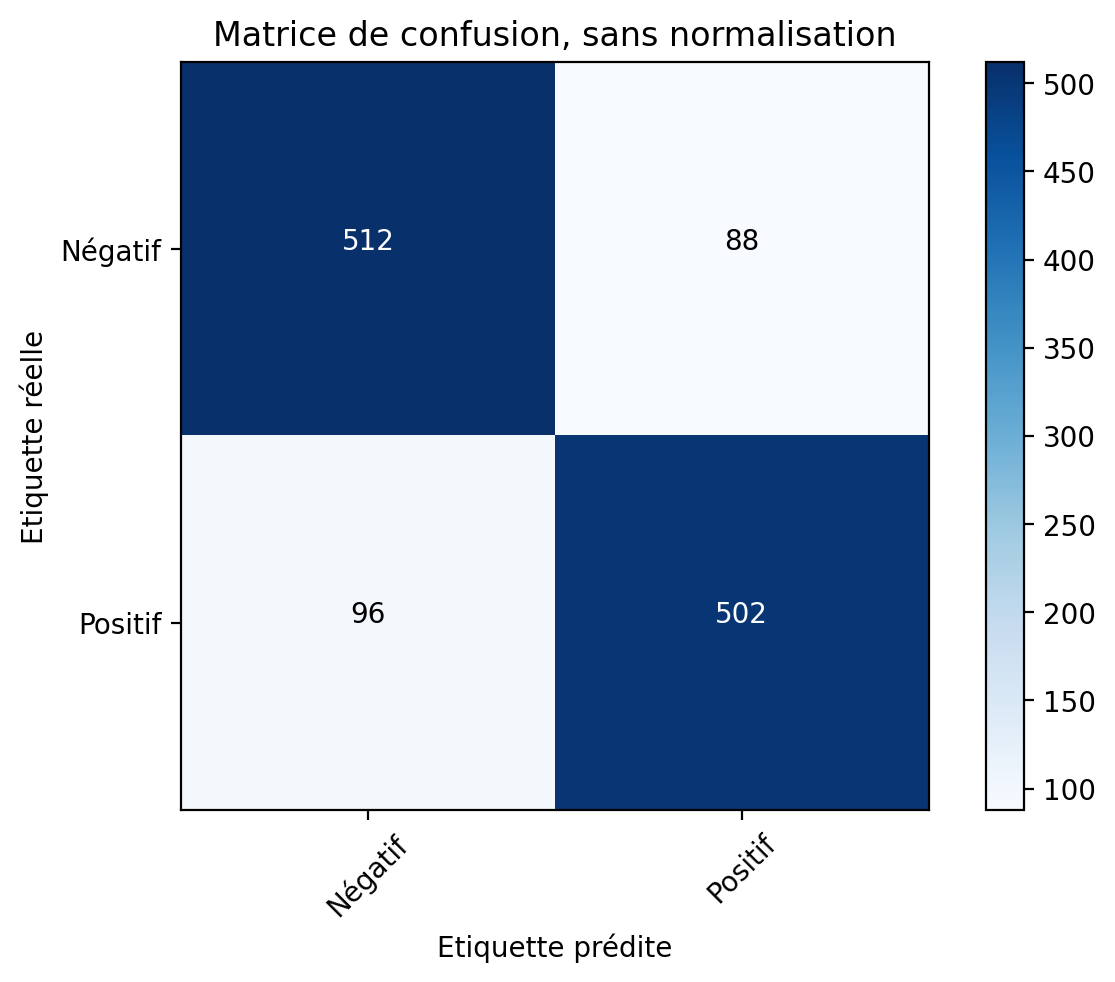

In [111]:
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(confusion_matrix(Y_valid, Y_valid_pred_f), 
                      classes=id2label, 
                      title='Matrice de confusion, sans normalisation')
plt.show()


In [112]:
# on teste si une pondération TFIDF améliore les résultats
clf_t = LogisticRegression(
        #random_state=0, 
        solver='lbfgs',    # algo d'optimisation (ici minimisation de la perte cross-entropie)
        multi_class='ovr', # stratégie "one versus rest"
        penalty='l2', # hyperparamètre de régularisation
        C=1.0, # hyperparamètre de régularisation
        n_jobs=2
)

clf_t.fit(X_train_t, Y_train)

# --------- prediction sur le test---------------
Y_valid_pred_t = clf_t.predict(X)
print("SCORE OF LOGISTIC REGRESSION ON VALID (tfidf): %.3f" % accuracy_score(Y_valid, Y_valid_pred_t))
    

# --------- prediction sur le train--------------
Y_train_pred_t = clf_t.predict(X_train_t)
print("SCORE OF LOGISTIC REGRESSION ON TRAIN (tfidf): %.3f" % accuracy_score(Y_train, Y_train_pred))

#@@ => on peut voir que le tfidf n'a pas un gros impact sur les résultats

NameError: name 'X_train_t' is not defined

## Un autre type de classifieur linéaire : les SVM

### TODO6: Appliquez l'apprentissage, la prédiction et l'évaluation, en utilisant cette fois un classifieur de type **SVM** (**support vector machine**), avec les hyperparamètres par défaut
- cf. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- Comparez **avec et sans utilisation de Tfidf** (CountVectorizer versus TfidfVectorizer).

**NB** : en apprentissage automatique, on distingue:
* les **paramètres**, qui sont des variables dont les valeurs sont fixées grâce au processus d'apprentissage. Celui-ci est en général un problème d'optimisation, résolu
  * soit de manière 
  * soit de manière approchée et itérative, auquel cas, en général, les paramètres sont initialisés (au hasard ou avec des valeurs pré-apprises sur d'autres tâches) et ajustés itérativement
* des **hyperparamètres**, qui sont des valeurs fixées en amont du processus d'apprentissage
  * chaque algo d'apprentissage va de paire avec un certain nombre d'hyperparamètres à choisir avant l'apprentissage
  * par exemple, pour un apprentissage de type régression logistique, on peut choisir d'inclure ou pas un terme régularisateur à la fonction de perte (cf. supra l'option penalty='l2' pour l'instance de LogisticRegression)
  * et en amont, les divers pré-traitements constituent des hyperparamètres
    * utilisation des formes fléchies, des lemmes ou des stems
    * pondération tf.idf ou pas
    * minusculisation ou pas
    * suppression ou pas des accents
    * si tf.idf, utilisation diverse des options max_df, min_df, max_features
    * etc...


In [ ]:
from sklearn import svm

# TODO 
# apprentissage SVM
# **avec et sans utilisation de Tfidf** (CountVectorizer versus TfidfVectorizer)
# prédiction
# évaluation sur corpus "valid" et sur corpus "train" (et affichage)


## Le réglage des hyperparamètres ("tuning hyperparameters")

Certains algorithmes vont avoir des performances très différentes selon les valeurs des hyperparamètres. Rechercher de bonnes valeurs d'hyperparamètres se dit **régler les hyperparamètres** (en anglais **tuning hyperparameters**).

Cela reste très expérimental, et fastidieux en particulier parce qu'on ne peut pas isoler les hyperparamètres les uns des autres: la meilleure valeur trouvée pour A, avec B=b, ne sera pas forcément la meilleure valeur pour A avec B=b'.

On en est simplement réduit à tester plusieurs combinaisons d'hyperparamètres, et choisir la meilleure sur ces tests. Plusieurs stratégies existent pour définir les combinaisons à tester:
* par tatonnement
  * éventuellement ok pour commencer à avoir une idée de l'ordre de grandeur des valeurs fonctionnant bien
  * mais il est recommandé d'avoir ensuite une approche plus systématique
* avec une **recherche en grille** (**grid search**): on teste de manière systématique les combinaisons de valeurs
  * par exemple on teste toutes les combinaisons avec A prenant les valeurs a, a'', a''' et B prenant les valeurs b, b' => 6 combinaisons.
  * mais le nb de combinaisons à tester peut devenir rapidement trop important
* ou encore avec une recherche aléatoire de combinaisons


### La validation croisée ("cross-validation")


**NB**: l'évaluation des performances pour chaque combinaison d'hyperparamètres doit être faite **sur des exemples non utilisés à l'apprentissage**. 
Une solution serait d'utiliser le corpus valid, mais cela biaiserait les résultats: la meilleure combinaison d'hyperparamètres obtenue serait celle valable pour le corpus valid. On veut garder celui-ci pour une évaluation finale.

C'est pourquoi on utilise plutôt la **validation croisée** (**cross-validation**) pour évaluer la performances de chaque combinaison d'hyperparamètes.

### BONUS TODO 7: explorez GridSearchCV et lancer une recherche en grille avec la grille d'hyperparamètres fournies infra.


In [ ]:
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import StratifiedKFold

# définition des combinaisons d'hyperparamètres à tester
# comme l'existence de certains hyperparamètres dépend de la valeur d'autres hyperparamètre,
# ces combinaisons sont définies comme des dictionnaires
param_grid = [
    {'C': [0.001, 0.1, 1, 10, 100], 
     'kernel': ['linear']},
    {'C': [0.1, 1, 10, 100], 
     'gamma': ['scale','auto', 0.001], # gamma n'est pertinent que si kernel=rbf
     'kernel': ['rbf']},
    ]

# on utilise un vectorizer trouvé en faisant varier diverses options
vectorizer = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy,
                                            max_features = 10000,
                                            min_df = 2,
                                            max_df = 0.7)
X_train_f = vectorizer.fit_transform(df['train']['lemmas'])
X_valid_f = vectorizer.transform(df['valid']['lemmas'])

#TODO BONUS grid search
